Tutorial: topology optimization using pyfe3d
===

Date: 14 of October 2024

Author: Saullo G. P. Castro

Cite this tutorial as:

Castro, SGP (2024). General-purpose finite element solver based on Python and Cython (Version 0.5.0). Zenodo. DOI: https://doi.org/10.5281/zenodo.6573489.


Importing Python modules
---

In [1]:
import numpy as np
from numpy import isclose
from scipy.sparse.linalg import cg
from scipy.sparse import coo_matrix
from scipy.optimize import minimize

from pyfe3d.shellprop_utils import isotropic_plate
from pyfe3d import Quad4R, Quad4RData, Quad4RProbe, INT, DOUBLE, DOF

Creating mesh
---

In [2]:
data = Quad4RData()
probe = Quad4RProbe()
nx = 39
ny = 39
N = DOF*nx*ny

a = 3.0
b = 3.0

c = 3
E0 = 203.e9 # Pa
nu = 0.33

h = 0.003 # m

xtmp = np.linspace(0, a, nx)
ytmp = np.linspace(0, b, ny)
xmesh, ymesh = np.meshgrid(xtmp, ytmp)
ncoords = np.vstack((xmesh.T.flatten(), ymesh.T.flatten(), np.zeros_like(ymesh.T.flatten()))).T

x = ncoords[:, 0]
y = ncoords[:, 1]
z = ncoords[:, 2]
ncoords_flatten = ncoords.flatten()

nids = 1 + np.arange(ncoords.shape[0])
nid_pos = dict(zip(nids, np.arange(len(nids))))
nids_mesh = nids.reshape(nx, ny)
n1s = nids_mesh[:-1, :-1].flatten()
n2s = nids_mesh[1:, :-1].flatten()
n3s = nids_mesh[1:, 1:].flatten()
n4s = nids_mesh[:-1, 1:].flatten()

num_elements = len(n1s)
print('# number of elements', num_elements)

nodes = list(zip(n1s, n2s, n3s, n4s))


# number of elements 1444


Calculate the stiffness matrix for a vector of design variables "rho"
---

The Young moduli of every element is calculated using the power law: $E=\rho^c E_0$, where $E_0$ is the original Young modulus.

In [3]:
def calc_K(rho):
    E = rho**c*E0

    KC0r = np.zeros(data.KC0_SPARSE_SIZE*num_elements, dtype=INT)
    KC0c = np.zeros(data.KC0_SPARSE_SIZE*num_elements, dtype=INT)
    KC0v = np.zeros(data.KC0_SPARSE_SIZE*num_elements, dtype=DOUBLE)

    quads = []
    init_k_KC0 = 0
    i = 0
    for n1, n2, n3, n4 in zip(n1s, n2s, n3s, n4s):
        prop = isotropic_plate(thickness=h, E=E[i], nu=nu, calc_scf=True)
        i += 1
        pos1 = nid_pos[n1]
        pos2 = nid_pos[n2]
        pos3 = nid_pos[n3]
        pos4 = nid_pos[n4]
        r1 = ncoords[pos1]
        r2 = ncoords[pos2]
        r3 = ncoords[pos3]
        normal = np.cross(r2 - r1, r3 - r2)[2]
        assert normal > 0
        quad = Quad4R(probe)
        quad.n1 = n1
        quad.n2 = n2
        quad.n3 = n3
        quad.n4 = n4
        quad.c1 = DOF*nid_pos[n1]
        quad.c2 = DOF*nid_pos[n2]
        quad.c3 = DOF*nid_pos[n3]
        quad.c4 = DOF*nid_pos[n4]
        quad.init_k_KC0 = init_k_KC0
        quad.update_rotation_matrix(ncoords_flatten)
        quad.update_probe_xe(ncoords_flatten)
        quad.update_KC0(KC0r, KC0c, KC0v, prop)
        quads.append(quad)
        init_k_KC0 += data.KC0_SPARSE_SIZE

    KC0 = coo_matrix((KC0v, (KC0r, KC0c)), shape=(N, N)).tocsc()

    return KC0


Sensitivity of the stiffness matrix with respect to the vector "rho"
---

The local support of $\rho_i$ in vector $\vec{\rho} = \{\rho_1, \rho_2, \dots, \rho_i, \dots, \rho_N\}$ makes it easy to calculate the sensitivity.

$$\frac{\partial E}{\partial \rho}\big\rvert_i = c \rho_i^{c-1} E_0$$

In [4]:
def dKdrho(rho, i):
    dEdrho = c*rho[i]**(c-1)*E0
    prop = isotropic_plate(thickness=h, E=dEdrho, nu=nu, calc_scf=True)

    KC0r = np.zeros(1*data.KC0_SPARSE_SIZE, dtype=INT)
    KC0c = np.zeros(1*data.KC0_SPARSE_SIZE, dtype=INT)
    KC0v = np.zeros(1*data.KC0_SPARSE_SIZE, dtype=DOUBLE)

    n1, n2, n3, n4 = nodes[i]
    pos1 = nid_pos[n1]
    pos2 = nid_pos[n2]
    pos3 = nid_pos[n3]
    pos4 = nid_pos[n4]
    r1 = ncoords[pos1]
    r2 = ncoords[pos2]
    r3 = ncoords[pos3]
    normal = np.cross(r2 - r1, r3 - r2)[2]
    assert normal > 0
    quad = Quad4R(probe)
    quad.n1 = n1
    quad.n2 = n2
    quad.n3 = n3
    quad.n4 = n4
    quad.c1 = DOF*nid_pos[n1]
    quad.c2 = DOF*nid_pos[n2]
    quad.c3 = DOF*nid_pos[n3]
    quad.c4 = DOF*nid_pos[n4]
    quad.init_k_KC0 = 0
    quad.update_rotation_matrix(ncoords_flatten)
    quad.update_probe_xe(ncoords_flatten)
    quad.update_KC0(KC0r, KC0c, KC0v, prop)

    KC0 = coo_matrix((KC0v, (KC0r, KC0c)), shape=(N, N)).tocsc()

    return KC0



Applying boundary conditions and forces
---

In [5]:
bk = np.zeros(N, dtype=bool)
check = isclose(x, 0) & (isclose(y, 0.) | isclose(y, b))
bk[0::DOF] = check
bk[1::DOF] = check
# making it a 2D membrane problem
bk[2::DOF] = True
bk[3::DOF] = True
bk[4::DOF] = True

bu = ~bk

# applying load along u at x=a
# nodes at vertices get 1/2 of the force
fext = np.zeros(N)
ftotal = -1000.
print('ftotal', ftotal)
# at x=0
check = isclose(x, a) & isclose(y, 0)
fext[1::DOF][check] = ftotal


ftotal -1000.0


Performing topology optimization
---

In [6]:
uu = None
K = None

def jac(rho):
    """Adjoint gradient of the compliance with respect to each density in 'rho'
    """
    global uu, K
    # K = calc_K(rho=rho)
    # Kuu = K[bu, :][:, bu]
    u = np.zeros(N)
    # PREC = np.max(1/Kuu.diagonal())
    # uu, info = cg(PREC*Kuu, PREC*fext[bu], atol=1e-3)
    u[bu] = uu
    dCdrho = np.zeros(num_elements)
    for i in range(num_elements):
        dCdrho[i] = - u.T @ dKdrho(rho, i) @ u
    return dCdrho


def rel_volume(rho):
    target_rel_volume = 0.4
    constr = target_rel_volume - np.sum(rho)/num_elements
    return constr


def objective(rho):
    global uu, K
    K = calc_K(rho)
    Kuu = K[bu, :][:, bu]
    PREC = np.max(1/Kuu.diagonal())
    uu, info = cg(PREC*Kuu, PREC*fext[bu], atol=1e-3)
    compl = uu.T @ Kuu @ uu
    print('# obj', compl)
    return compl


constraints = [
    {'type': 'ineq', 'fun': rel_volume},
]
bounds = [[1.e-6, 1.] for _ in range(num_elements)]

rho = np.ones(num_elements)
topopt = minimize(objective, rho, jac=jac, method='SLSQP',
               constraints=constraints, bounds=bounds)

# obj 0.03656858898675277
# obj 0.5547638094651913
# obj 0.35106069976731524
# obj 0.3215979475255099
# obj 0.26155065221967616
# obj 0.2447341311076434
# obj 0.22158155519550016
# obj 0.2110542607798679
# obj 0.20017326095359275
# obj 0.1899385104265735
# obj 0.18559066078665587
# obj 0.17579991247268809
# obj 0.1695368390646748
# obj 0.16614085821270308
# obj 0.16067894839400845
# obj 0.15745805351723577
# obj 0.1543229529344281
# obj 0.14997568672655667
# obj 0.14805508446344015
# obj 0.1443873346907818
# obj 0.1420002577011633
# obj 0.1387533680825178
# obj 0.13659894670685266
# obj 0.1336785942032554
# obj 0.1302100407756137
# obj 0.12576457530613608
# obj 0.12055160240888262
# obj 0.11620300114017221
# obj 0.11263125359507889


/Users/saullogiovanip/miniconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


# obj 0.11144236537240935


/Users/saullogiovanip/miniconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:438: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Users/saullogiovanip/miniconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:498: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])


# obj 0.1093976103320863
# obj 0.10641891141655721
# obj 0.10528727474306264
# obj 0.10298874900519467
# obj 0.1007075298824823
# obj 0.09893335389752553
# obj 0.09774328677980391
# obj 0.09603914335961679
# obj 0.09477669903683783
# obj 0.0933967618079123
# obj 0.09213737826774447
# obj 0.09103602206543925
# obj 0.08992870637624946
# obj 0.08876037150415103
# obj 0.08761904956984673
# obj 0.08676634286601623
# obj 0.08586449260199747
# obj 0.08463077613202426
# obj 0.08368662929320665
# obj 0.08274835885449637
# obj 0.08183925637394532
# obj 0.0810026586568174
# obj 0.07992119435209558
# obj 0.07887065589514056
# obj 0.07808017107093869
# obj 0.07737506257498095
# obj 0.07671351488737689
# obj 0.07580524529586612
# obj 0.07490326203365288
# obj 0.0741322844147335
# obj 0.07333014135170007
# obj 0.07272968991453943
# obj 0.07221843513446832
# obj 0.07179850909572436
# obj 0.07134393524717482
# obj 0.07054215800944728
# obj 0.07010145418080924
# obj 0.0695357918453487
# obj 0.0691065403

Checking the result of the topology optimization
---

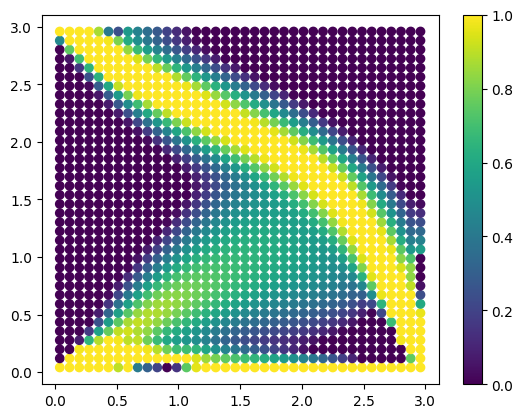

In [7]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

xcg = np.zeros((num_elements, 3))
i = 0
for n1, n2, n3, n4 in zip(n1s, n2s, n3s, n4s):
    pos1 = nid_pos[n1]
    pos2 = nid_pos[n2]
    pos3 = nid_pos[n3]
    pos4 = nid_pos[n4]
    r1 = ncoords[pos1]
    r2 = ncoords[pos2]
    r3 = ncoords[pos3]
    r4 = ncoords[pos4]

    xcg[i] = (r1 + r2 + r3 + r4)/4
    i += 1

plt.clf()
plt.scatter(xcg[:, 0], xcg[:, 1], c=topopt.x, vmin=0, vmax=1)
plt.colorbar()
plt.show()